In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # Allow printing multiple outputs from each cell

In [130]:
# Dependency for the computations
import numpy as np

# Dependency only for the charts
import matplotlib.pyplot as plt
import seaborn as sns # Make matplotlib charts look better
sns.set(style='ticks')

# Dependency only for adding methods to classes dynamically in jupyter (Jupyter Dynamic Classes)
# See https://github.com/jupyter/notebook/issues/1243 and https://alexhagen.github.io/jdc/
import jdc

In [18]:
%matplotlib inline

A literate programming notebook written as I follow http://neuralnetworksanddeeplearning.com/chap1.html (as recommended in fast.ai course lesson 2 notes)

This is basically a 'My First Neural Network' notebook with (hopefully) copious documentation, built to learn NumPy and solidify the concepts for me before going back to using the higher-level libraries such as Keras/TensorFlow. It won't use GPU, and it isn't optimised for performance. It's just about checking I understand the concepts fully, and to explore the NumPy APIs.

The end goal (based on the chapter 1 content) is to build an entry for the Kaggle MNIST competition, using a neural network, written from scratch - and for that neural network to be general enough for other problems. 

# Perceptrons

A perceptron takes any number of binary inputs $x_0, x_1,..., x_n$ and outputs a single binary value. First we compute $\sum_j x_j w_j$, where each $w_j \in \mathbb{R}$ is a weight (and there are equal numbers of inputs $x_i$ and weights $w_i$). This is the dot product of the two vectors, $\mathbf{x} \cdot \mathbf{w}$, which we can compute using the `np.dot` method.

In [13]:
x = [0, 0, 1, 1, 0] # 5 binary inputs
w = [1, 2, 3, 4, 1] # 5 real-valued weights

dot = np.dot(x, w)
print(dot)

7


So for a perceptron we see that because of the binary-valued inputs, the output of $\mathbf{x} \cdot \mathbf{w}$ is simply the sum of weights $w_j$ where $x_j = 1$. 

As mentioned, the output of a perceptron is in fact binary-valued, and this is done using a threshold: If $\mathbf{x} \cdot \mathbf{w} \le threshold$ then the perceptron outputs 0, otherwise it outputs 1. 

We replace the treshold with bias $-b = threshold$, and move it to the other side of the inequality, such that we have: If $\mathbf{x} \cdot \mathbf{w} + b \le 0$ then the perceptron outputs 0, otherwise it outputs 1. 

So we could fully capture a perceptron's behaviour with a simple method:

In [132]:
def perceptron(x, w, bias):
    if np.dot(x, w) + bias <= 0:
        return 0
    else: 
        return 1

# For example, using our x and w from before
x = [0, 0, 1, 1, 0] 
w = [1, 2, 3, 4, 1] 
perceptron(x, w, bias=7)
perceptron(x, w, bias=-10)

1

0

In [133]:
# From the book, using the perceptron to implement NAND 
w = [-2, -2]
bias = 3

for x1, x2 in [(0,0), (0,1), (1,0), (1,1)]:
    perceptron([x1,x2], w, bias)

1

1

1

0

We can in fact use a perceptron to learn any linearly separable function, including NAND. To show this, let's consider how a perceptron learns. 

We start with randomly initialised weights and bias terms. We also pass in training data, in tuples of (input, output) ie (x, y). For a binary function this is ((x1, x2), y).

Then for each **epoch** (ie the number of times we want to learn), we take each training example, and using its input and our current weights we compute the current value of the perceptron on that input. We find the difference between the expected output `y` and the current output, the error term. Note that this must be computed `y - output` - the order matters. The error term will either be 0, 1 or -1. 

We adjust the weights in each position $w_i$ by $w_i += \eta * error * x_i$ ($\eta$, eta is just a learning rate that we can tweak - it changes how quickly the weights change for wrong examples.) We adjust the bias by $\eta * error$, since it's not linked to any weight directly. 

Assuming the input training data is linearly separable this algorithm will converge to 100% accuracy in a finite number of epochs. 


To demonstrate this, we'll define a function to train a perceptron - and demonstrate it on the NAND case. 

In [134]:
def train_perceptron(training_data, epochs=30, eta=1):
    x_len = len(training_data[0][0]) # Tuples of ((xs...), y) - want len xs

    w = np.random.rand(x_len) # Random starting weights equal length to x_len, 0-1
    bias = np.random.rand() # Random starting bias, 0-1

    errors = {} # Count errors at each epoch

    for i in range(epochs):
        errors[i] = 0
        for x, y in training_data:
            output = perceptron(x, w, bias)
            error = y - output
            if error != 0:
                errors[i]+=1

            w[0] += eta * error * x[0]
            w[1] += eta * error * x[1]
            bias += eta * error
    
    return w, bias, errors


training_data = [((0,0), 1), ((0, 1), 1), ((1,0), 1), ((1,1), 0)] # Tuples of ((x1,x2), x1 NAND x2)

w, b, errors = train_perceptron(training_data)

Text(0.5,0,'epoch')

Text(0,0.5,'errors')

Text(0.5,1,'Errors at each epoch')

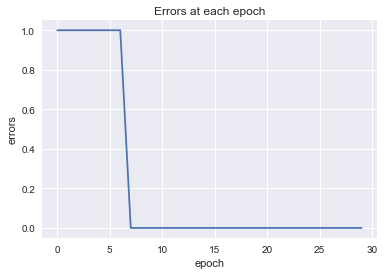

In [91]:
plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)

(-1, 1)

(-1, 1)

Text(0.5,1,'Separation boundary found')

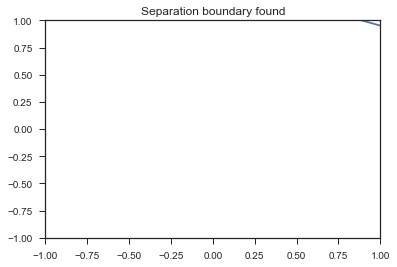

In [218]:
x_intersect = [0,-bias/w[1]]
y_intersect = [-bias/w[0],0]
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Separation boundary found')
plt.plot(x_intersect, y_intersect)

We can see the effect of using a smaller eta variable on the same training data:

Text(0.5,0,'epoch')

Text(0,0.5,'errors')

Text(0.5,1,'Errors at each epoch')

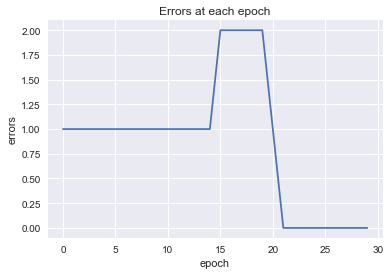

In [94]:
w, b, errors = train_perceptron(training_data, eta=0.05)

plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)

Perceptrons have some limitations:

- They only converge for linearly separable problems, which most interesting problems are not
- Because they use a step function, we can't make small tweaks to their output - it's either 0 or 1

The way we deal with the first issue will be by building networks of neurons, where the output of one layer can be inputs to the next layer. This allows us to solve complex problems (or, mathematically - can approximate to an arbitrary accuracy any function). However this exasperates our second problem - without being able to tweak our perceptrons in a predictable way we're not going to be able to create a trainable network of them. 

For this reason, we change the non-linearity, that is the **activation function**. Our computed $\mathbf{x} \cdot \mathbf{w} + b$ doesn't need to change, but instead of using the inequality with 0, we pass this value to a different function.

# Sigmoid neurons

The sigmoid neuron uses the activation function $\sigma(z) = \frac{1}{1+e^-z}$, where z is our computed $\mathbf{x} \cdot \mathbf{w} + b$. Before we code this, we can examine its shape:

In [124]:
def sigmoid_fn(x):
    return 1/(1+np.exp(-x))

Text(0.5,1,'Sigmoid')

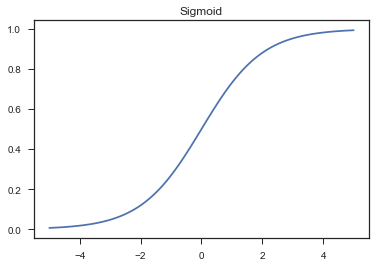

In [125]:
xs = np.linspace(-5,5,100) # 100 evenly spaced values between -5 and 5
ys = sigmoid_fn(xs)

plt.title('Sigmoid')
plt.plot(xs, ys)

Text(0.5,1,'Step function')

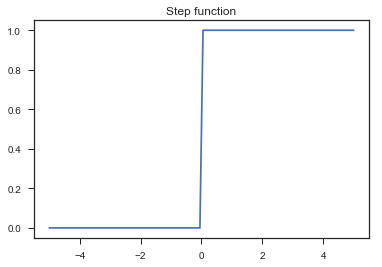

In [110]:
# Compare this to the step function:

def step(x):
    return 1 if x>0 else 0

xs = np.linspace(-5,5,100) # 100 evenly spaced values between -5 and 5
ys = [step(x) for x in xs]

plt.title('Step function')
plt.plot(xs, ys)

We can see that the sigmoid is a smoothed step function, maintaining the bounds of 0 and 1, but changing by only a small amount each time its input changes. This is the only difference between the sigmoid and perceptron, but it turns out to be significant. 

At this point it makes sense to generalise our code to define a neuron, with a view to eventually building up a neural network - that is, a network of layers of neurons. So let's define a neuron:

In [157]:
class Neuron:
    def __init__(self, num_inputs, activation_function):
        # We always initialise a neuron with random weights and bias
        # We must pass an activation function, as this is different for each type of neuron
        self.weights = np.random.rand(num_inputs)
        self.bias = np.random.rand()
        self.num_inputs = num_inputs # This will let us generalise updates
        self.activation_function = activation_function
        
    def _compute_value(self, xs):
        # Compute the value of the neuron for the given inputs
        return np.dot(xs, self.weights) + self.bias
    
    def get_value(self, xs):
        return self.activation_function(self._compute_value(xs))

Essentially, a neuron knows how to compute its value from its weights and bias term, and it has an activation function, which takes such a value and computes the desired output for the neuron. 

In [126]:
# So a perceptron is simply:
perceptron = Neuron(2, activation_function = step)
perceptron.get_value([0,0])

# And a sigmoid is simply:
sigmoid = Neuron(2, activation_function = sigmoid_fn)
sigmoid.get_value([0,0])

1

0.64448315602197881

Now we can re-implement our learning method using the generic neuron (and thus supporting any given activation function)

In [206]:
%%add_to Neuron
def train(self, training_data):
    errors = {}

    for i in range(epochs):
        errors[i] = 0
        for X, y in training_data:
            output = self.get_value(X)
            error = y - output
            if np.absolute(error) > 0.5:
                errors[i]+=1

            # Update each weight in turn, and the bias
            for j in range(self.num_inputs):
                self.weights[j] += eta * error * X[j]
            self.bias += eta * error
    
    return errors

In [213]:
sigmoid = Neuron(2, activation_function = step) # Make sure we re-create the neuron to get the new method included
errors = sigmoid.train(training_data)

(-1, 1)

(-1, 1)

Text(0.5,1,'Separation boundary found')

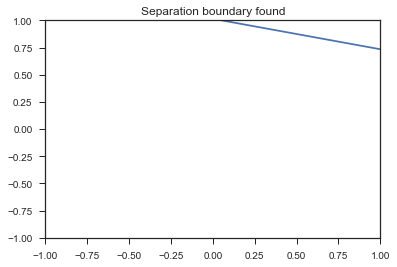

In [214]:
x_intersect = [0,-sigmoid.bias/sigmoid.weights[1]]
y_intersect = [-sigmoid.bias/sigmoid.weights[0],0]
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('Separation boundary found')
plt.plot(x_intersect, y_intersect)

Text(0.5,0,'epoch')

Text(0,0.5,'errors')

Text(0.5,1,'Errors at each epoch')

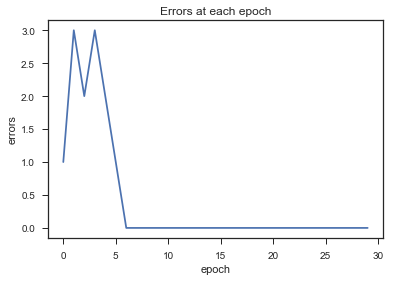

In [217]:
plt.figure()
xs = errors.keys()
ys = errors.values()
plt.xlabel('epoch')
plt.ylabel('errors')
plt.title('Errors at each epoch')
plt.plot(xs, ys)